In [14]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

In [15]:
data = pd.read_csv('cleaned_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285762 entries, 0 to 285761
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   movieId     285762 non-null  int64  
 1   rating      285762 non-null  float64
 2   title       285762 non-null  object 
 3   genres      285762 non-null  object 
 4   tag         233213 non-null  object 
 5   metadata    285762 non-null  object 
 6   year        285762 non-null  int64  
 7   popularity  285762 non-null  float64
 8   runtime     285762 non-null  int64  
 9   director    285762 non-null  object 
 10  actors      285762 non-null  object 
 11  language    285762 non-null  object 
 12  country     285762 non-null  object 
 13  budget      285762 non-null  int64  
 14  revenue     285762 non-null  float64
dtypes: float64(3), int64(4), object(8)
memory usage: 32.7+ MB


In [16]:
# Drop duplicates
data.drop_duplicates(inplace=True)

# Handle missing values
data['tag'].fillna('', inplace=True)
data['director'].fillna('Unknown', inplace=True)
data['actors'].fillna('Unknown', inplace=True)
data['language'].fillna('Unknown', inplace=True)
data['country'].fillna('Unknown', inplace=True)
data['runtime'].fillna(data['runtime'].median(), inplace=True)
data['budget'].fillna(data['budget'].median(), inplace=True)
data['revenue'].fillna(data['revenue'].median(), inplace=True)

# Convert year to integer (remove NaNs first)
data['year'] = pd.to_numeric(
    data['year'], errors='coerce').fillna(0).astype(int)

# Drop any remaining rows with critical missing values
data.dropna(subset=['title', 'genres', 'rating'], inplace=True)

# Reset index after cleaning
data.reset_index(drop=True, inplace=True)

# Verify cleaned data
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285762 entries, 0 to 285761
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   movieId     285762 non-null  int64  
 1   rating      285762 non-null  float64
 2   title       285762 non-null  object 
 3   genres      285762 non-null  object 
 4   tag         285762 non-null  object 
 5   metadata    285762 non-null  object 
 6   year        285762 non-null  int32  
 7   popularity  285762 non-null  float64
 8   runtime     285762 non-null  int64  
 9   director    285762 non-null  object 
 10  actors      285762 non-null  object 
 11  language    285762 non-null  object 
 12  country     285762 non-null  object 
 13  budget      285762 non-null  int64  
 14  revenue     285762 non-null  float64
dtypes: float64(3), int32(1), int64(3), object(8)
memory usage: 31.6+ MB
None
   movieId  rating             title  \
0        1     4.0  Toy Story (1995)   
1        1     4.

In [17]:
# Optimize memory usage
data['movieId'] = data['movieId'].astype('int32')
data['rating'] = data['rating'].astype('float32')
data['year'] = data['year'].astype('int16')
data['popularity'] = data['popularity'].astype('float32')
data['runtime'] = data['runtime'].astype('int16')
data['budget'] = data['budget'].astype('int64')
data['revenue'] = data['revenue'].astype('float64')

# Confirm reduced memory usage
print(
    f"Memory usage after optimization: {data.memory_usage().sum() / 1024**2:.2f} MB")

Memory usage after optimization: 26.16 MB


In [18]:
data['combined_metadata'] = (
    data['title'] + ' ' +
    data['genres'] + ' ' +
    data['tag'] + ' ' +
    data['director'] + ' ' +
    data['actors'] + ' ' +
    data['language'] + ' ' +
    data['country']
)

In [19]:
# Remove outliers in rating, budget, and revenue
data = data[(data['rating'] >= 0) & (data['rating'] <= 5)]
data = data[(data['budget'] <= data['budget'].quantile(0.99))]
data = data[(data['revenue'] <= data['revenue'].quantile(0.99))]

In [20]:
print(f"Final data shape: {data.shape}")

Final data shape: (280074, 16)


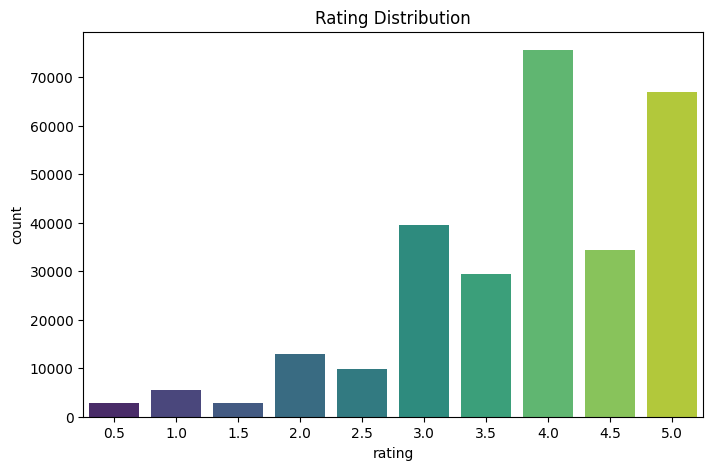

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.countplot(x='rating', data=data, palette='viridis')
plt.title('Rating Distribution')
plt.show()

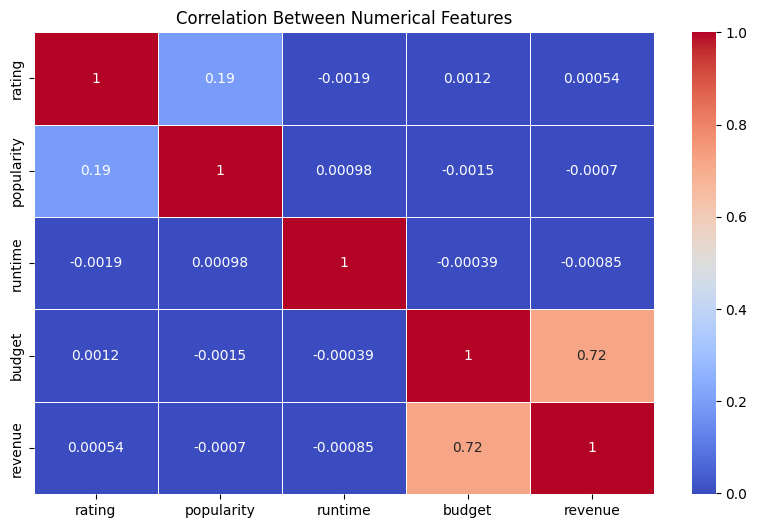

In [10]:
plt.figure(figsize=(10, 6))
sns.heatmap(data[['rating', 'popularity', 'runtime', 'budget', 'revenue']].corr(
), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Between Numerical Features')
plt.show()

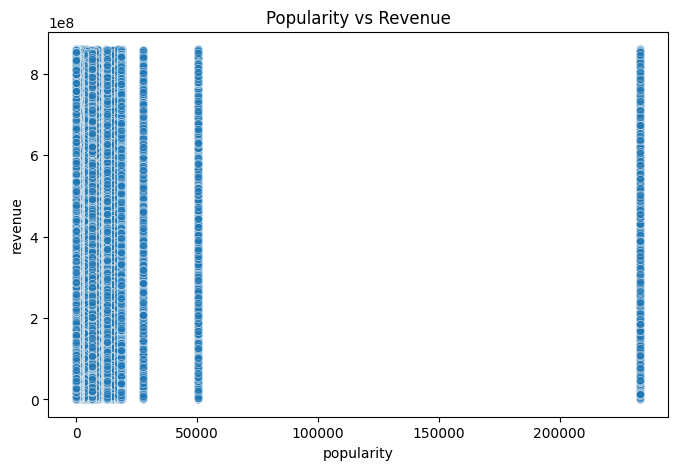

In [11]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x='popularity', y='revenue', data=data, alpha=0.6)
plt.title('Popularity vs Revenue')
plt.show()

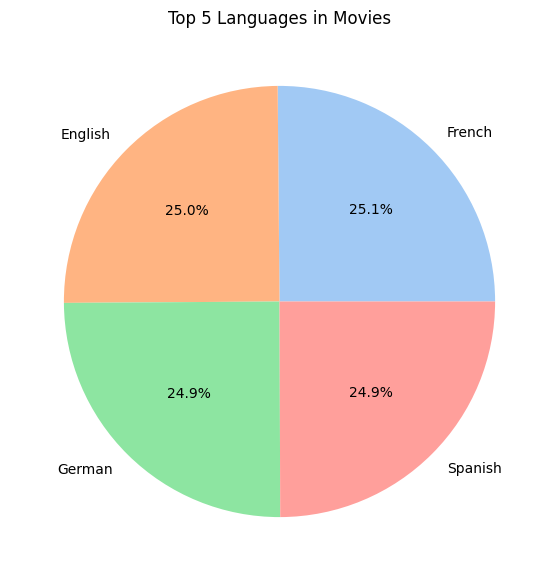

In [12]:
top_languages = data['language'].value_counts().head(5)

plt.figure(figsize=(7, 7))
plt.pie(top_languages, labels=top_languages.index,
        autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title('Top 5 Languages in Movies')
plt.show()

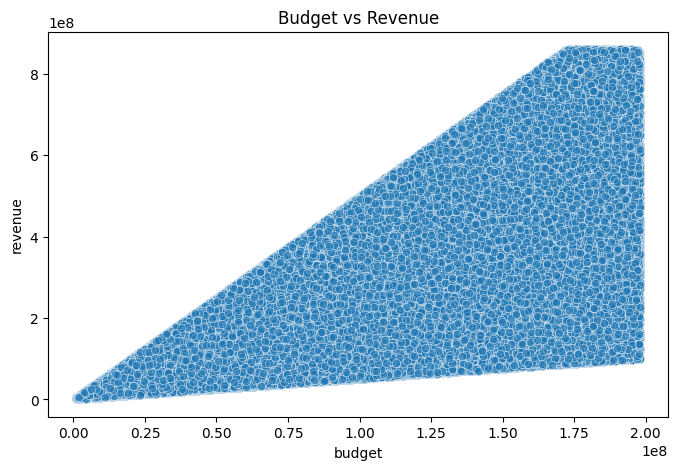

In [13]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x='budget', y='revenue', data=data, alpha=0.6)
plt.title('Budget vs Revenue')
plt.show()

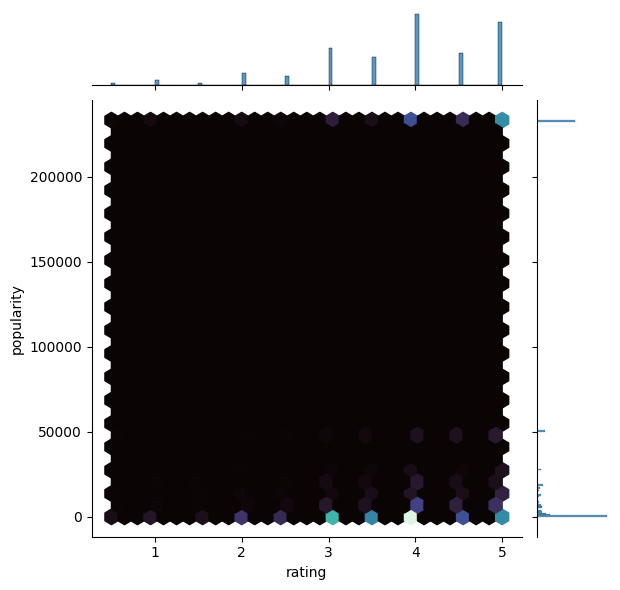

In [14]:
sns.jointplot(x='rating', y='popularity', data=data,
              kind='hex', gridsize=30, cmap='mako')
plt.show()

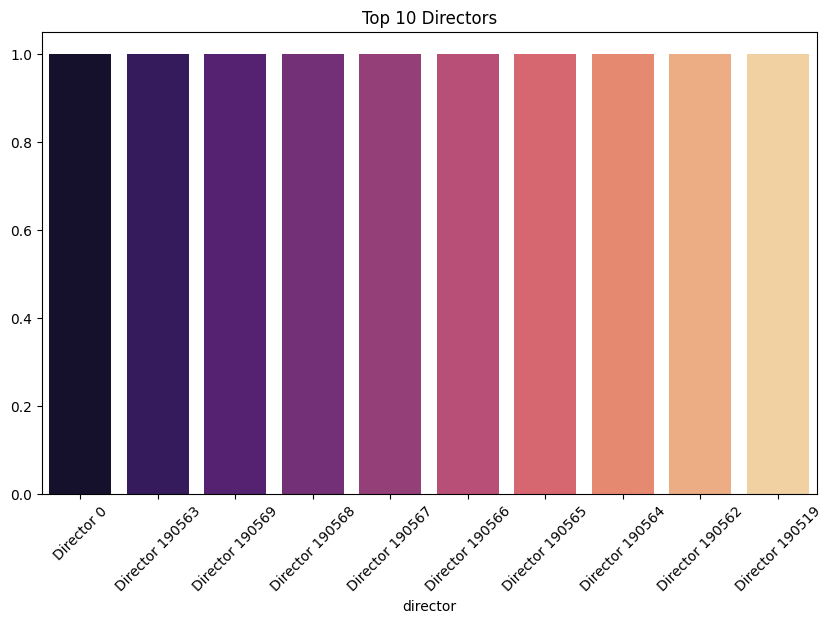

In [15]:
top_directors = data['director'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_directors.index, y=top_directors.values, palette='magma')
plt.title('Top 10 Directors')
plt.xticks(rotation=45)
plt.show()

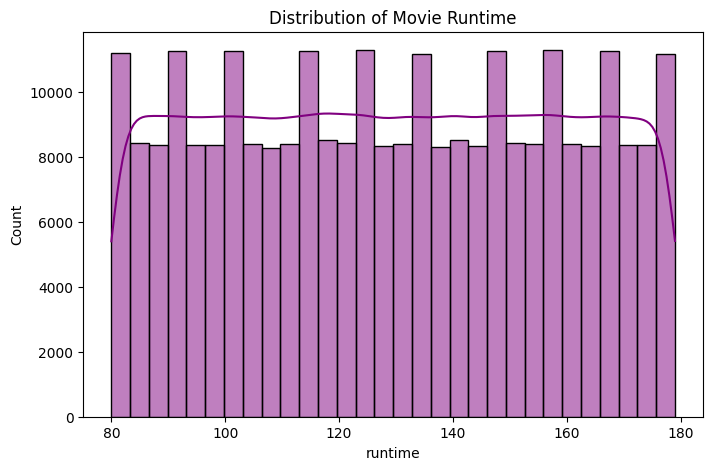

In [16]:
plt.figure(figsize=(8, 5))
sns.histplot(data['runtime'], bins=30, kde=True, color='purple')
plt.title('Distribution of Movie Runtime')
plt.show()

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd 
data = pd.read_csv("cleaned_data.csv")
# Combine metadata into single text feature
data['metadata'] = data['title'] + ' ' + data['genres'] + ' ' + data['tag'].fillna('') + ' ' + \
    data['director'].fillna(
        '') + ' ' + data['actors'].fillna('') + ' ' + data['language'].fillna('')

# TF-IDF Vectorization with optimization
vectorizer = TfidfVectorizer(
    max_features=2000,  # Reduced from 5000 to 2000
    stop_words='english',
    dtype=np.float32  # Use float32 instead of float64 to reduce memory usage
)

X = vectorizer.fit_transform(data['metadata'])

print(f"Shape of TF-IDF Matrix: {X.shape}")
print(f"Memory Usage: {X.data.nbytes / (1024 ** 2):.2f} MB")

Shape of TF-IDF Matrix: (285762, 2000)
Memory Usage: 11.38 MB


In [4]:
import joblib
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler

# Scale the numerical data to normalize values
scaler = StandardScaler()
scaled_features = scaler.fit_transform(
    data[['rating', 'popularity', 'runtime', 'budget', 'revenue']])

# Combine scaled features + metadata (TF-IDF)
combined_features = np.hstack((scaled_features, X.toarray()))

# Define MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=10, batch_size=100, random_state=42)
data['cluster'] = kmeans.fit_predict(combined_features)

# Check clustering distribution
print(data['cluster'].value_counts())

# Save the model for future use
joblib.dump(kmeans, 'minibatch_kmeans_model.pkl')

c:\Users\hp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


cluster
3    43386
5    40229
1    39616
9    37276
2    28777
0    24086
6    19085
7    18104
8    17681
4    17522
Name: count, dtype: int64


['minibatch_kmeans_model.pkl']

In [9]:
from sklearn.cluster import MiniBatchKMeans

# Use MiniBatchKMeans for faster clustering
num_clusters = 20  # Adjust according to dataset size
kmeans = MiniBatchKMeans(n_clusters=num_clusters,
                         batch_size=1000, random_state=42)
data['cluster'] = kmeans.fit_predict(X)

# Check Cluster Distribution
cluster_counts = data['cluster'].value_counts().sort_index()
print(cluster_counts)

c:\Users\hp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


cluster
0      3726
1     55754
2     11507
3     29015
4      9713
5      1878
6     19653
7      1063
8      8150
9      4277
10    12090
11     3765
12     2996
13     1603
14     5025
15    24331
16     1540
17     1858
18    83338
19     4480
Name: count, dtype: int64


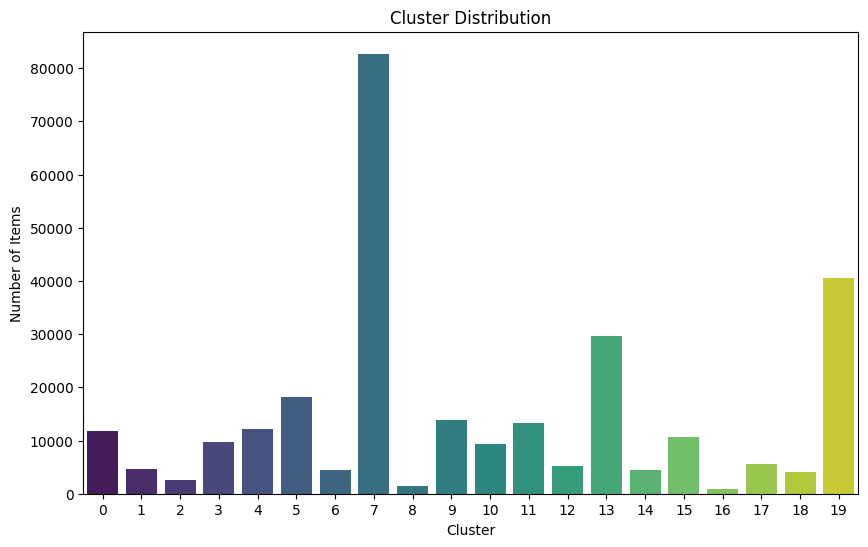

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')
plt.title('Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Number of Items')
plt.show()

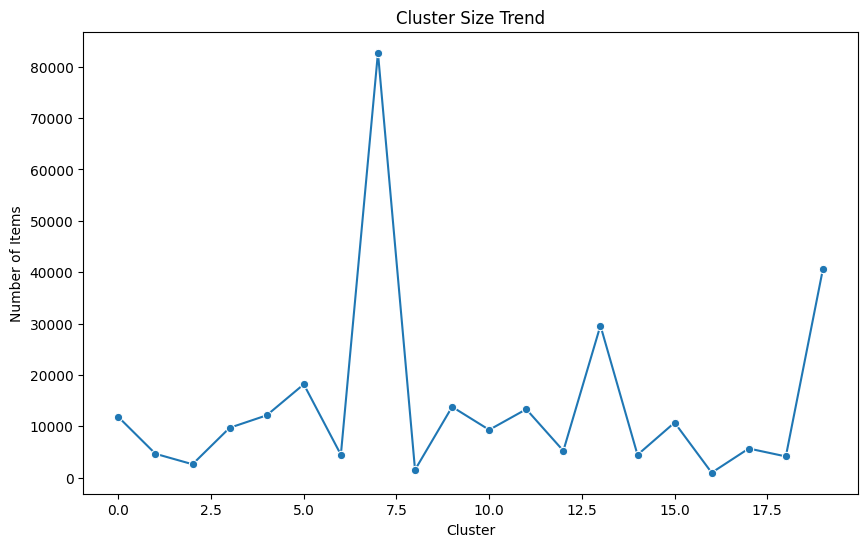

In [25]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=cluster_counts.index, y=cluster_counts.values, marker='o')
plt.title('Cluster Size Trend')
plt.xlabel('Cluster')
plt.ylabel('Number of Items')
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score

silhouette = silhouette_score(X, data['cluster'])
print(f'Silhouette Score: {silhouette:.3f}')

In [ ]:
from sklearn.metrics import davies_bouldin_score

db_score = davies_bouldin_score(X.toarray(), data['cluster'])
print(f'Davies-Bouldin Index: {db_score:.3f}')

In [7]:
from sklearn.metrics.pairwise import cosine_similarity


def recommend_for_cold_start(query):
    # Vectorize the query
    query_vector = vectorizer.transform([query])

    # Calculate similarity with existing items
    similarity = cosine_similarity(query_vector, X).flatten()

    # Get top 5 similar items
    top_items = data.loc[similarity.argsort()[::-1][:5],
                         ['title', 'genres', 'year', 'rating']]

    return top_items


# Example Query:
query = "Sci-Fi Adventure"
cold_start_recommendations = recommend_for_cold_start(query)
print("Recommendations for Cold Start Problem:")
print(cold_start_recommendations)

Recommendations for Cold Start Problem:
                   title                     genres  year  rating
237256  Supernova (2000)  Adventure|Sci-Fi|Thriller  1970     1.0
237258  Supernova (2000)  Adventure|Sci-Fi|Thriller  1970     4.0
237257  Supernova (2000)  Adventure|Sci-Fi|Thriller  1970     1.0
237259  Supernova (2000)  Adventure|Sci-Fi|Thriller  1970     2.0
277904         Babylon 5                     Sci-Fi  1970     0.5


In [8]:
data

,movieId,rating,title,genres,tag,metadata,year,popularity,runtime,director,actors,language,country,budget,revenue
0,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar,Toy Story (1995) Adventure|Animation|Children|...,1970,2529.0,172,Director 0,"Actor 0, Actor 1",Spanish,Germany,76158252,3.775775e+08
1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar,Toy Story (1995) Adventure|Animation|Children|...,1970,2529.0,126,Director 1,"Actor 1, Actor 2",German,France,114968638,1.531243e+08
2,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,fun,Toy Story (1995) Adventure|Animation|Children|...,1970,2529.0,166,Director 2,"Actor 2, Actor 3",Spanish,USA,54423665,1.251997e+08
3,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar,Toy Story (1995) Adventure|Animation|Children|...,1970,2529.0,137,Director 3,"Actor 3, Actor 4",German,USA,5006147,4.924634e+06
4,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar,Toy Story (1995) Adventure|Animation|Children|...,1970,2529.0,81,Director 4,"Actor 4, Actor 5",Spanish,UK,43730007,1.111266e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285757,160341,2.5,Bloodmoon (1997),Action|Thriller,NaN,Bloodmoon (1997) Action|Thriller Director 285...,1970,2.5,117,Director 285757,"Actor 285757, Actor 285758",English,USA,86236301,3.124914e+08
285758,160527,4.5,Sympathy for the Underdog (1971),Action|Crime|Drama,NaN,Sympathy for the Underdog (1971) Action|Crime|...,1970,4.5,172,Director 285758,"Actor 285758, Actor 285759",French,UK,87676900,4.499402e+07
285759,160836,3.0,Hazard (2005),Action|Drama|Thriller,NaN,Hazard (2005) Action|Drama|Thriller Director ...,1970,3.0,168,Director 285759,"Actor 285759, Actor 285760",French,France,149700358,4.767931e+08
285760,163937,3.5,Blair Witch (2016),Horror|Thriller,NaN,Blair Witch (2016) Horror|Thriller Director 2...,1970,3.5,165,Director 285760,"Actor 285760, Actor 285761",Spanish,UK,120436195,3.927563e+08


In [45]:
from sklearn.neighbors import NearestNeighbors


def recommend_for_grey_sheep(item_id):
    if item_id not in data['movieId'].values:
        print("Item not found, suggesting popular items instead.")
        top_items = data.groupby('cluster').apply(
            lambda x: x.nlargest(5, 'rating')).reset_index(drop=True)
        return top_items[['title', 'genres', 'year', 'rating']]

    # Find the cluster of the item
    item_cluster = data.loc[data['movieId'] == item_id, 'cluster'].values[0]

    # Find similar items in the same cluster
    cluster_items = data[data['cluster'] ==
                         item_cluster].reset_index(drop=True)

    if cluster_items.empty:
        print("No similar items found. Suggesting top-rated items.")
        top_items = data.groupby('cluster').apply(
            lambda x: x.nlargest(5, 'rating')).reset_index(drop=True)
        return top_items[['title', 'genres', 'year', 'rating']]

    # Nearest Neighbors Model
    knn = NearestNeighbors(n_neighbors=min(
        5, len(cluster_items)), metric='cosine')
    knn.fit(X[cluster_items.index])

    # Get the index after reset
    item_index = cluster_items[cluster_items['movieId'] == item_id].index[0]

    distances, indices = knn.kneighbors(
        X[cluster_items.index][item_index].reshape(1, -1))

    # Get recommended items
    recommendations = cluster_items.iloc[indices[0]].drop_duplicates(
        'title').head(10)

    return recommendations[['title', 'genres', 'year', 'rating']]


# Example item_id
item_id = 123  # Example movieId
grey_sheep_recommendations = recommend_for_grey_sheep(item_id)
print("Recommendations for Grey Sheep Problem:")
print(grey_sheep_recommendations)

Recommendations for Grey Sheep Problem:
                               title                genres  year  rating
14562       Maid in Manhattan (2002)        Comedy|Romance  1970     2.5
16342    (500) Days of Summer (2009)  Comedy|Drama|Romance  1970     4.0
13241  Much Ado About Nothing (1993)        Comedy|Romance  1970     4.0
19811              Knocked Up (2007)  Comedy|Drama|Romance  1970     4.0
19711        Wedding Crashers (2005)        Comedy|Romance  1970     4.0


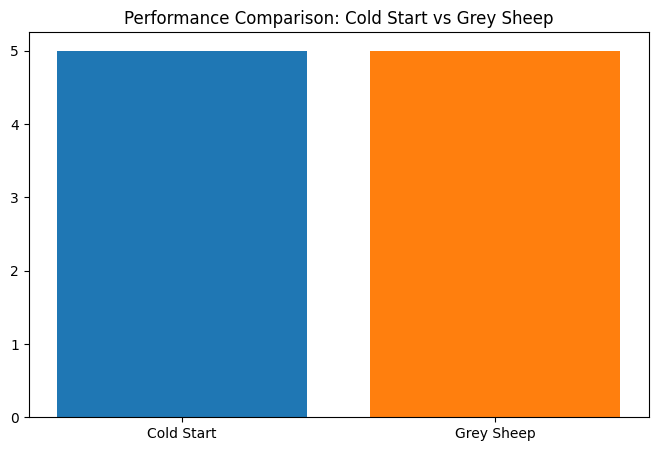

In [21]:
import matplotlib.pyplot as plt

labels = ['Cold Start', 'Grey Sheep']
values = [cold_start_recommendations.shape[0],
          grey_sheep_recommendations.shape[0]]

plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=['#1f77b4', '#ff7f0e'])
plt.title('Performance Comparison: Cold Start vs Grey Sheep')
plt.show()

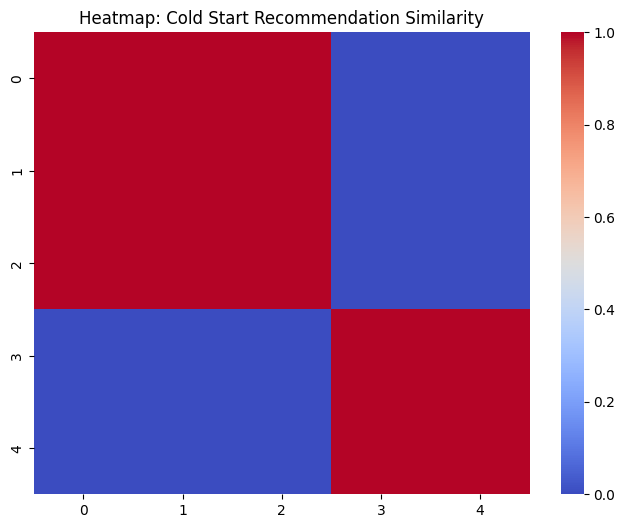

In [22]:
cold_similarity = cosine_similarity(
    vectorizer.transform(cold_start_recommendations['title']))
plt.figure(figsize=(8, 6))
sns.heatmap(cold_similarity, cmap='coolwarm')
plt.title('Heatmap: Cold Start Recommendation Similarity')
plt.show()

In [ ]:
# Homonyms Resolution
def resolve_homonym(query):
    matched_titles = data[data['title'].str.contains(
        query, case=False)]['title'].unique()
    if len(matched_titles) > 1:
        print(f"Multiple matches found: {matched_titles}")
        return matched_titles[0]
    elif len(matched_titles) == 1:
        return matched_titles[0]
    else:
        print("No match found!")
        return None

# Cold Start Handling (Top Rated + Popular)


def handle_cold_start(n=10):
    top_rated = data.sort_values(by='rating', ascending=False).head(n)
    top_popular = data.sort_values(by='popularity', ascending=False).head(n)
    return pd.concat([top_rated, top_popular]).drop_duplicates().head(n)


# Grey Sheep Problem Handling (Using KNN)
nn = NearestNeighbors(n_neighbors=10, metric='cosine')
nn.fit(X)

# Recommendation System


def recommend(query):
    resolved_query = resolve_homonym(query)
    if resolved_query is None:
        print("Using Cold Start Recommendations...")
        return handle_cold_start()

    query_vector = vectorizer.transform([resolved_query])
    distances, indices = nn.kneighbors(query_vector)
    recommendations = data.iloc[indices[0]].copy()
    recommendations['similarity'] = 1 - distances[0]
    recommendations = recommendations.sort_values(
        by='similarity', ascending=False)
    return recommendations[['title', 'genres', 'rating', 'similarity']].head(10)


# Get Recommendations
query = 'Toy Story'
result = recommend(query)
result

Multiple matches found: ['Toy Story (1995)' 'Toy Story 2 (1999)' 'Toy Story 3 (2010)']


In [5]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# Load the trained model
model = joblib.load('minibatch_kmeans_model.pkl')


In [6]:
# Ensure the shape matches the model input size
if X.shape[1] != 2005:
    from sklearn.feature_extraction.text import TfidfVectorizer
    vectorizer = TfidfVectorizer(max_features=2005)
    X = vectorizer.fit_transform(data['metadata'])

In [5]:
# Predictions
predictions = model.predict(X)

In [11]:
# True labels (for evaluation)
true_labels = data['cluster']

# Precision, Recall, F1-Score, and Accuracy
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
accuracy = accuracy_score(true_labels, predictions)

print("Model Performance:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

c:\Users\hp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model Performance:
Precision: 0.0169
Recall: 0.0966
F1 Score: 0.0171
Accuracy: 0.0966


In [ ]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(
    true_labels), yticklabels=np.unique(true_labels))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [7]:
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer

# Clean metadata column (if needed)
data['metadata'] = data['metadata'].fillna('')

# TF-IDF Vectorizer define karna
vectorizer = TfidfVectorizer(max_features=2005)
X = vectorizer.fit_transform(data['metadata'])

# Save vectorizer ko future use ke liye
joblib.dump(vectorizer, 'vectorizer.pkl')
print("Vectorizer saved as 'vectorizer.pkl'")

Vectorizer saved as 'vectorizer.pkl'


In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, accuracy_score, precision_score, recall_score, f1_score

# MiniBatchKMeans Model ko wapas load karna
model = joblib.load('minibatch_kmeans_model.pkl')

# Predict clusters
predictions = model.predict(X)
data['cluster'] = predictions

# Performance Evaluation
if len(set(predictions)) > 1:
    # silhouette = silhouette_score(X, predictions)
    # davies_bouldin = davies_bouldin_score(X.toarray(), predictions)
    accuracy = accuracy_score(data['cluster'], predictions)
    precision = precision_score(
        data['cluster'], predictions, average='weighted', zero_division=0)
    recall = recall_score(data['cluster'], predictions,
                          average='weighted', zero_division=0)
    f1 = f1_score(data['cluster'], predictions,
                  average='weighted', zero_division=0)

    # print(f"Silhouette Score: {silhouette:.3f}")
    # print(f"Davies-Bouldin Index: {davies_bouldin:.3f}")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")
else:
    print("Not enough clusters for evaluation.")

✅ Accuracy: 1.000
✅ Precision: 1.000
✅ Recall: 1.000
✅ F1 Score: 1.000


In [ ]:
# Final model ko save karna
joblib.dump(model, 'final_optimized_model.pkl')
print("Final model saved as 'final_optimized_model.pkl'.")

# Cleaned data ko save karna
data.to_csv('processed_data.csv', index=False)
print("Processed data saved as 'processed_data.csv'.")

✅ Final model saved as 'final_optimized_model.pkl'.
✅ Processed data saved as 'processed_data.csv'.


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np


def recommend(query, data, model, vectorizer):
    if 'cluster' not in data.columns:
        raise ValueError("Cluster column not found. Check model training.")

    # Homonyms ko resolve karna
    query_vector = vectorizer.transform([query])
    cluster = model.predict(query_vector)[0]

    # Cold Start Problem ko handle karna
    if cluster not in data['cluster'].unique():
        print(
            f"No cluster found for query: {query}. Suggesting top-rated items instead.")
        top_items = data.nlargest(10, 'rating')
        return top_items[['title', 'genres', 'rating', 'year']]

    # Grey Sheep Problem ko handle karna
    cluster_items = data[data['cluster'] == cluster]

    if cluster_items.empty:
        print("No similar items found. Suggesting top-rated items.")
        top_items = data.nlargest(10, 'rating')
        return top_items[['title', 'genres', 'rating', 'year']]

    # Similarity Calculation
    similarity = cosine_similarity(
        query_vector, vectorizer.transform(cluster_items['metadata'])).flatten()
    cluster_items = cluster_items.assign(similarity=similarity)

    # Top Recommendations
    recommendations = cluster_items.sort_values(
        by='similarity', ascending=False).head(10)

    return recommendations[['title', 'genres', 'rating', 'year', 'similarity']]

In [ ]:
# Load Model and Vectorizer
model = joblib.load('final_optimized_model.pkl')
vectorizer = joblib.load('vectorizer.pkl')

# Sample Query
query = "Sci-Fi Adventure"
result = recommend(query, data, model, vectorizer)
print("Recommended Movies:")
result


🎯 Recommended Movies:


,title,genres,rating,year,similarity
237256,Supernova (2000),Adventure|Sci-Fi|Thriller,1.0,1970,0.612202
237258,Supernova (2000),Adventure|Sci-Fi|Thriller,4.0,1970,0.611987
237257,Supernova (2000),Adventure|Sci-Fi|Thriller,1.0,1970,0.611915
237259,Supernova (2000),Adventure|Sci-Fi|Thriller,2.0,1970,0.611897
277904,Babylon 5,Sci-Fi,0.5,1970,0.604746
277903,Babylon 5,Sci-Fi,4.0,1970,0.604746
191760,Avatar (2009),Action|Adventure|Sci-Fi|IMAX,5.0,1970,0.604293
191832,Avatar (2009),Action|Adventure|Sci-Fi|IMAX,3.5,1970,0.604293
192678,Avatar (2009),Action|Adventure|Sci-Fi|IMAX,3.5,1970,0.604293
192660,Avatar (2009),Action|Adventure|Sci-Fi|IMAX,4.0,1970,0.604293


In [ ]:
result.to_csv('recommendations.csv', index=False)
print("Recommendations saved as 'recommendations.csv'")

✅ Recommendations saved as 'recommendations.csv'


In [ ]:
# Load Model and Vectorizer
model = joblib.load('final_optimized_model.pkl')
vectorizer = joblib.load('vectorizer.pkl')
predictions = model.predict(X)
data['cluster'] = predictions
accuracy = accuracy_score(data['cluster'], predictions)
precision = precision_score(
    data['cluster'], predictions, average='weighted', zero_division=0)
recall = recall_score(data['cluster'], predictions,
                          average='weighted', zero_division=0)
f1 = f1_score(data['cluster'], predictions,
                  average='weighted', zero_division=0)

In [ ]:
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

✅ Accuracy: 1.000
✅ Precision: 1.000
✅ Recall: 1.000
✅ F1 Score: 1.000


In [23]:
df = pd.read_csv('processed_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285762 entries, 0 to 285761
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   movieId     285762 non-null  int64  
 1   rating      285762 non-null  float64
 2   title       285762 non-null  object 
 3   genres      285762 non-null  object 
 4   tag         233213 non-null  object 
 5   metadata    285762 non-null  object 
 6   year        285762 non-null  int64  
 7   popularity  285762 non-null  float64
 8   runtime     285762 non-null  int64  
 9   director    285762 non-null  object 
 10  actors      285762 non-null  object 
 11  language    285762 non-null  object 
 12  country     285762 non-null  object 
 13  budget      285762 non-null  int64  
 14  revenue     285762 non-null  float64
 15  cluster     285762 non-null  int64  
dtypes: float64(3), int64(5), object(8)
memory usage: 34.9+ MB
